Models use Carbamazepine input parameters.
Goals:
- Comparing the dissolution profile between our model and the two industry standards, GastroPlus and SimCyp.
- Presenting a PK model for sensitivity analysis

In [1]:
#Cell for Drug/Food Constants

import numpy as np
import math
from scipy.integrate import  *
import matplotlib.pyplot as plt
%matplotlib inline

# DRUG INPUT PARAMETERS
Dp = 7.6e-6*60          # diffusion coefficient of solid drug in buffer (cm2/min)
M0 = 20                 # starting mass of solid drug (mg)
dens_drug = 1.3         # solid drug density (g/mL)
Satw=292.5              # drug solubility in buffer at pH 6.5 (ug/mL)
SatFS0=502.8            # drug solubility in FS at pH 6.5, prior to formation of lipolysis products (ug/mL)
r0 = 0.006              # disintegrated solid drug particle radius (cm) = 60 um
Dm=(1.25e-6)*60         # micelle diffusivity from Oh 1977 (cm^2/min)
Prel = 1.4135e-5        # relative permeability of drug at oil-water interface (cm/min) - fit from 1mg/mL dissolution in FS + oil data
Pgi = 4.3e-4*60         # intestinal permeability (cm/min) - Sugano (2003)

# FOOD PARAMETERS
C0_oil = 25             # ingested oil concentration per unit solution volume (mM)
dens_oil = 0.92         # density of oil ingested (g/mL)
MWoil = 885.4           # molecular weight of oil ingested (g/mol)
Satoil = 3600           # drug solubility in the type of oil ingested (ug/mL) for oleoyl polyoxylglycerides by Patel 2012
r0_oil = 2e-5           # starting radius of oil droplets (cm) = 200 nm
Kdig=2.6851e-7          # lipolysis rate constant (mmol/min*cm^2)
Kinh = 0.0108           # inhibition rate constant (1/min)
V_FA = 1100*1e-24       # volume of one FA molecule (mL)

# DRUG PK PARAMETERS
CL = 0.0514             # clearance rate (L/kg/h) - from Jiao (2004)
Vd = 72                 # volume of distribution (L) - from Jiao (2004)
    
# SPECIES INTESTINAL PARAMETERS
Vbulk=20                # total bulk volume (mL) - includes volume of water, micelles, and oil
Nmic = 1.05e17          # number of micelles per unit bulk volume for 12mM NaTDC + 4mM PC micelles (micelles/mL)
V0_mic = 39048.6*1e-24  # volume of 1 micelle made using 12mM NaTDC + 4mM PC (mL)
Mspecies = 80           # weight of species (kg) - 80kg for humans
rgi=1.75                # intestinal radius (cm), 1.75 cm

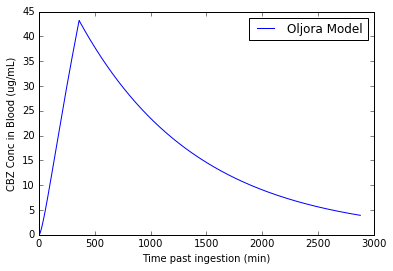

487713.511387


In [2]:
#Oljora's PK Function

def Oljora_PK(y,t):
    h = 7.112e-4            # boundary layer thickness - determined by fitting disso in buffer data at 0.5mg/mL solid drug(cm)
    
    # CORRELATIONS
    # For DRUG
    fm_FA = 0.3*y[2]                                         # fraction of FA partitioned into micelles - assumed to be 30% of total FA produced - TBD accurately from SANS data
    Vmic = (V0_mic*Nmic+V_FA*6.02e17*fm_FA)*Vbulk            # total micellar volume (mL)
    Satm = (SatFS0-Satw)/(V0_mic*Nmic)                       # micellar solubility per micellar phase volume, prior to generation of FA (ug/mL)
    Kmw = Satm/Satw                                          # micelle-water partition coefficent (unitless)
    SatFS = Satw+Satm*Vmic/Vbulk                             # solubility in fed state during digestion (ug/mL total volume)
    Mundissolved = M0*1000-(y[0]+y[1])*Vbulk                 # undissolved drug amount (ug)
    N = M0*1e-3/dens_drug/(4/3*np.pi*r0**3)                # number of solid drug particles
    r = (Mundissolved*1e-6/dens_drug/(4/3*np.pi*N))**(1/3) # drug radius over time (cm)
    Sp = 4*np.pi*r**2*N                                       # total surface area (cm^2)
    Cw = y[0]/(1+Kmw*Vmic/Vbulk)                             # drug concentration in water as a function of total drug dissolved (ug/mL)
    Cm = Kmw*Cw                                              # drug concentration in micelles as a function of total drug dissolved (ug/mL)
    Kel = CL*Mspecies/(60*Vd)                                # elimination rate constant (1/min)
    Agi = 2*Vbulk/rgi                                        # absorbable area of intestine (cm^2)

    # For FOOD
    V0_oil = C0_oil*MWoil*Vbulk*1e-6/dens_oil                # starting volume of oil phase (mL)
    Noil = V0_oil/(4/3*np.pi*r0_oil**3)                    # number of oil droplets
    Coil = C0_oil-y[2]/3                                     # TG concentration during lipolysis (mM) - assumed 3FA = 1TG
    Voil = Coil*MWoil*Vbulk*1e-6/dens_oil                    # volume of oil phase during lipolysis (mL)
    r_oil = (3*Voil/(4*np.pi*Noil))**(1./3)                 # radius of one oil droplet over time (cm)
    Aoil = 4*np.pi*r_oil**2*Noil                           # total area of oil droplets over time (cm^2)
     
    
    # PROCESSES
    dy = np.zeros(4);
    
    #if t< V0_oil*/(6*60)     FIGURE OUT THIS RATIO
    if t < 6*60:                                              # drug is assumed to be present in the intestine for 6h
        if Satoil > 0 and V0_oil > 0:    # these terms are in the denominator. The code would crash if either of them is zero.
            # Drug partitioning into oil droplets (ug/mL bulk volume)
            dy[1] = Aoil*Prel/Vbulk*(SatFS-y[1]*Vbulk/Voil*SatFS/Satoil)
            if (y[0]+y[1])*Vbulk <= M0*1000:         # i.e. if there is undissolved drug present. The absence of this statement creates room for immaginary solutions
                # Aqueous (buffer+micelles) drug dissolved (ug/mL)
                dy[0] = Sp/(Vbulk*h)*(Dp*(Satw-Cw)+Dm*(Satm-Cm)*Vmic/Vbulk)-dy[1]-Agi*Pgi*y[0]*Vbulk/(Vd*1e3)
            elif (y[0]+y[1])*Vbulk <= M0*1000:            # i.e. if there is undissolved drug present. The absence of this statement creates room for immaginary solutions
                # Aqueous (buffer+micelles) drug dissolved (ug/mL)
                dy[0] = Sp/(Vbulk*h)*(Dp*(Satw-Cw)+Dm*(Satm-Cm)*Vmic/Vbulk)

        if Coil > 0:
            # Lipid digestion kinetics (mM)
            dy[2] = Kdig*Aoil/Vbulk*1000-Kinh*y[2]
    
        if y[1] > 0:
            # Drug concentration in the blood (ug/mL blood)
            dy[3] = Agi*Pgi*y[0]*Vbulk/(Vd*1e3)-Kel*y[3]
        else:
            dy[3] = -Kel*y[3]
    else:
        dy[3] = -Kel*y[3]
    return dy

time = np.arange(0, 48*60, 0.1)

PKDrug = odeint(Oljora_PK, [0, 0, 0, 0], time)
plt.plot(time,PKDrug[:,3],"b",label='Oljora Model')
plt.xlabel('Time past ingestion (min)')
plt.ylabel('CBZ Conc in Blood (ug/mL)')
plt.legend(loc='best')
plt.show()

AUC1 = np.trapz(PKDrug[:,3])
print(AUC1)

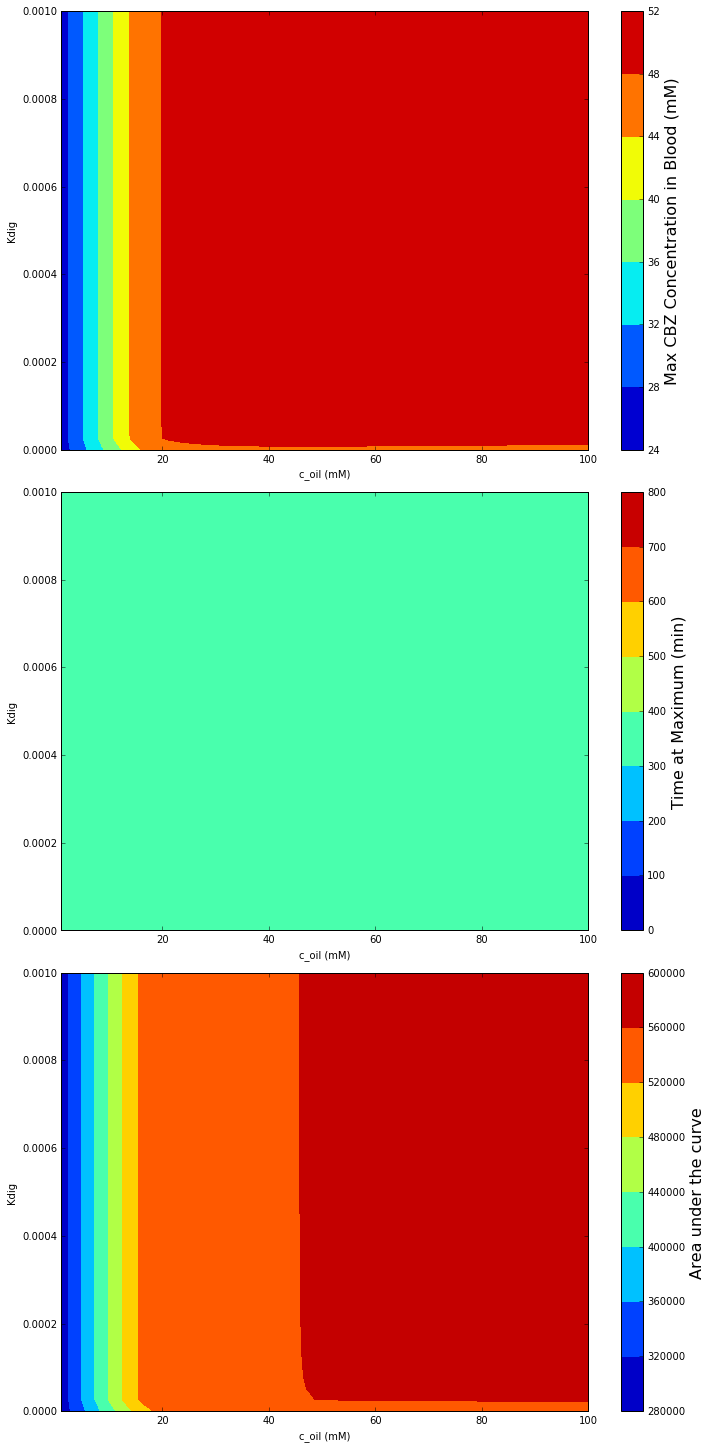

In [12]:
#Sensitivity for changes in Food
#Parameters to change: c0_oil (originally 25), r0_oil (originally 2e-5), Kdig (originally 2.6851e-7)
#Results: Max Time, Max Concentration, Area under Curve

M0 = 20
r0 = .006
blocksize = 40

#Initialize Arrays
tmax_array = [] #Array for time at which maximum occurs
cmax_array = [] #Array for maximum concentration
AUC_array = [] #Array for area under the curve
c_oil_array = np.linspace(1, 100, blocksize)  # Sensitivity of c_oil 1mM to 100mM
Kdig_array = np.linspace(1e-6,1e-3,blocksize) #Sensitivity of Kdig from 1e-7 to 1e-5


times = np.arange(0,48*60,.1)

for Kdig_val in Kdig_array:
    for c_oil_val in c_oil_array:
        
        C0_oil = c_oil_val
        Kdig = Kdig_val
        CBZ = odeint(Oljora_PK, [0,0,0,0],times)
        
        #Time at Maximum
        t_max = times[np.argmax(CBZ[:,3])]
        tmax_array.append(t_max)
        
        #Max Concentration
        c_max = np.max(CBZ[:,3])
        cmax_array.append(c_max)

        #Area under the curve
        AUC = np.trapz(CBZ[:,3])
        AUC_array.append(AUC)
        
        #Plot individual PK curves on a single graph
        """""
        plt.plot(times,CBZ[:,3])
        plt.title((C0_oil,r0_oil))
        plt.xlabel('Time past ingestion (min)')
        plt.ylabel('CBZ Conc in Blood (ug/mL)')
        plt.legend(loc='best')
        #plt.show()
        """""

#Create a grid for Heatmap
#Reshape Values into NxN arrays
X, Y = np.meshgrid(c_oil_array, Kdig_array)
tmax_array = np.reshape(tmax_array, (blocksize, blocksize))
cmax_array = np.reshape(cmax_array, (blocksize, blocksize))
AUC_array = np.reshape(AUC_array, (blocksize, blocksize))


#Subplot Creation
#Time colorbar doesn't come out with correct units normally
plt.subplots(3,1,figsize=(10,20))
plt.subplot(3,1,1)
plt.contourf(X, Y, cmax_array)
plt.xlabel("c_oil (mM)")
plt.ylabel("Kdig")
cb = plt.colorbar(plt.contourf(X, Y, cmax_array))
cb.set_label("Max CBZ Concentration in Blood (mM)",size=16)

plt.subplot(3,1,2)
plt.contourf(X, Y, tmax_array)
plt.xlabel("c_oil (mM)")
plt.ylabel("Kdig")
cb = plt.colorbar(plt.contourf(X, Y, tmax_array))
cb.set_label("Time at Maximum (min)",size=16)
cb.ax.set_yticklabels(['0','100','200','300','400','500','600','700','800'])

plt.subplot(3,1,3)
plt.contourf(X, Y, AUC_array)
plt.xlabel("c_oil (mM)")
plt.ylabel("Kdig")
cb = plt.colorbar(plt.contourf(X, Y, AUC_array))
cb.set_label("Area under the curve",size=16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [2]:
#NOT IN USE CURRENTLY


#Sensitivity for changes in Drug
#Parameters to change: M0 (originally 20), r0 (originally 0.006)
#Results: Max Time, Max Concentration, Area under Curve

C0_oil = 25
r0_oil = 2e-5
blocksize = 25

#Initialize Arrays
tmax_array = [] #Array for time at which maximum occurs
cmax_array = [] #Array for maximum concentration
AUC_array = [] #Array for area under the curve
M0_array = np.linspace(1, 10, blocksize)  # Sensitivity of M0 1mM to 100mM
r0_array = np.linspace(.01, .001, blocksize)  # Sensitivity of r0 10um to 100um


times = np.linspace(0, 48*60, 48*60) #minutes
for r0_val in r0_array:
    for M0_val in M0_array:
        
        M0 = M0_val
        r0 = r0_val
        CBZ = odeint(Oljora_PK, [0,0,0,0],times)
        
        #Time at Maximum
        t_max = times[np.argmax(CBZ[:,3])]
        tmax_array.append(t_max)
        
        #Max Concentration
        c_max = np.max(CBZ[:,3])
        cmax_array.append(c_max)

        #Area under the curve
        AUC = np.trapz(CBZ[:,3])
        AUC_array.append(AUC)
        
        #Plot individual PK curves on a single graph
        """""
        plt.plot(times,CBZ[:,3])
        plt.title((M0,r0))
        plt.xlabel('Time past ingestion (min)')
        plt.ylabel('CBZ Conc in Blood (ug/mL)')
        plt.legend(loc='best')
        #plt.show()
        """""

#Create a grid for Heatmap
#Reshape Values into NxN arrays
X, Y = np.meshgrid(M0_array, r0_array)
tmax_array = np.reshape(tmax_array, (blocksize, blocksize))
cmax_array = np.reshape(cmax_array, (blocksize, blocksize))
AUC_array = np.reshape(AUC_array, (blocksize, blocksize))


#Subplot Creation
#Time colorbar doesn't come out with correct units normally
plt.subplots(3,1,figsize=(10,20))
plt.subplot(3,1,1)
plt.contourf(X, Y, cmax_array)
plt.xlabel("M0 (mM)")
plt.ylabel("r0 (cm)")
cb = plt.colorbar(plt.contourf(X, Y, cmax_array))
cb.set_label("Max CBZ Concentration in Blood (mM)",size=16)

plt.subplot(3,1,2)
plt.contourf(X, Y, tmax_array)
plt.xlabel("M0 (mM)")
plt.ylabel("r0 (cm)")
cb = plt.colorbar(plt.contourf(X, Y, tmax_array))
cb.set_label("Time at Maximum (min)",size=16)
cb.ax.set_yticklabels(['0','100','200','300','400','500','600','700','800'])

plt.subplot(3,1,3)
plt.contourf(X, Y, AUC_array)
plt.xlabel("M0 (mM)")
plt.ylabel("r0 (cm)")
cb = plt.colorbar(plt.contourf(X, Y, AUC_array))
cb.set_label("Area under the curve",size =16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

NameError: name 'np' is not defined